In [1]:
import h5py # for working with HDF5 (Hierarchical Data Format) files
import numpy as np
import sklearn.svm
import matplotlib.pyplot as plt
import pandas as pd
import os
from V3.load_calcium_video import load_video_data, load_one_video
from V3.align_behavior_to_calcium import align_files_old_labels, align_files_new_labels
from V3.class_balance import check_class_imbalance_old, check_class_imbalance_new 
from V3.preprocessing_model import model_preprocessing
from V3.save_model_info import save_training_info
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.svm import LinearSVC

2023-05-19 23:50:57.328588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 23:50:57.367038: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
comment = "k-fold-cross validation, multiple videos, new labels"

experiment_ID = 'Exp_4.3.2-BPSVMt-one-video'

data_file = 'Animal3learnday11' #Animal3learnday8, Animal3Learnday9, Animal3Learnday10'

experiment_name = str(data_file)+"_"+str(experiment_ID)

train_test_split_strategy = "k-fold"

name = 'BPSVM'

model_version = str(name)+'_1'

# Which labels am I using? Old or New?
labels_type = 'new' # or 'old'

# Shuffle data? This to find chance performance
shuffled_labels = False

# Which architecture am I using 
architecture_type = 'standard' # or 'old'

# will you merge labels or not?
merge_labels = False

# Am I using one or multiple videos for training?
multiple_videos = False 

# store the initiation variables:
%store experiment_ID
%store data_file
%store experiment_name
%store train_test_split_strategy
%store name
%store model_version
%store labels_type
%store merge_labels
%store shuffled_labels
%store architecture_type
%store multiple_videos

Stored 'experiment_ID' (str)
Stored 'data_file' (str)
Stored 'experiment_name' (str)
Stored 'train_test_split_strategy' (str)
Stored 'name' (str)
Stored 'model_version' (str)
Stored 'labels_type' (str)
Stored 'merge_labels' (bool)
Stored 'shuffled_labels' (bool)
Stored 'architecture_type' (str)
Stored 'multiple_videos' (bool)


In [3]:
# # Define the name of the output directory
# output_dir = "output-svm"

# # Check if the output directory already exists
# if not os.path.exists(output_dir):
#     # Create the output directory
#     os.mkdir(output_dir)

#     # Create the balance, accuracy, loss, and cm directories inside the output directory
#     os.mkdir(os.path.join(output_dir, "balance"))
#     os.mkdir(os.path.join(output_dir, "accuracy"))
#     os.mkdir(os.path.join(output_dir, "loss"))
#     os.mkdir(os.path.join(output_dir, "cm"))
#     os.mkdir(os.path.join(output_dir, "architecture"))
#     os.mkdir(os.path.join(output_dir, "pickles"))
# else:
#     print(f"The directory {output_dir} already exists.")

# create output directory
output_dir = str(experiment_ID)+'_output'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    os.mkdir(os.path.join(output_dir, "balance"))
    os.mkdir(os.path.join(output_dir, "accuracy"))
    os.mkdir(os.path.join(output_dir, "loss"))
    os.mkdir(os.path.join(output_dir, "cm"))
    os.mkdir(os.path.join(output_dir, "architecture"))
    os.mkdir(os.path.join(output_dir, "pickles"))
    
%store output_dir

Stored 'output_dir' (str)


### Loading Calcium Videos

In [4]:
video_name_list = []
video_data_list = []

if multiple_videos == True:
    # paths to videos
    video_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.nwb", 
                   "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.nwb", 
                   "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.nwb"]
    # load the CSV file with the FOV information
    fov_info = pd.read_csv('/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/aligned_videos_animal3.csv')
    images = load_video_data(video_paths, fov_info, video_name_list, video_data_list)

else:
    # change the path if you're using another video other than animal3learnday11
    # video_path = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211028_174510_animal2learnday11.nwb"]    
    video_path = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211028_181307_animal3learnday11.nwb"]
    images = load_one_video(video_path, video_name_list, video_data_list)


20211028_181307_animal3learnday11.nwb recording_20211028_181307-PP-BP-MC
(24589, 393, 444)


In [5]:
images[0].shape

(393, 444)

In [6]:
# Check if the video has been loaded correctly
images[:1]

array([[[175, 181, 182, ..., 181, 181, 180],
        [170, 174, 173, ..., 177, 176, 179],
        [175, 175, 168, ..., 180, 176, 178],
        ...,
        [180, 182, 175, ..., 170, 173, 167],
        [177, 188, 181, ..., 177, 179, 180],
        [184, 184, 183, ..., 188, 182, 174]]], dtype=int16)

In [7]:
# Determine the size of the calcium video dataset
num_of_frames = images.shape[0]
img_height = images.shape[1]
img_width = images.shape[2]
print("The number of video frames is ", num_of_frames, " and the frame dimensions (height x width) are: ", img_height, "X", img_width)

The number of video frames is  24589  and the frame dimensions (height x width) are:  393 X 444


### Loading Calcium Traces

In [8]:
path = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/animal3.h5"

In [9]:
# manually change from which videos you want to extract calcium traces
list_of_traces = []

if multiple_videos == True:
    with (h5py.File(path, 'r')) as f:
        traces_8 = np.array(f['traces/animal3learnday8/deconvolved'])
        list_of_traces.append(traces_8)
        traces_9 = np.array(f['traces/animal3learnday9/deconvolved'])
        list_of_traces.append(traces_9)
        traces_10 = np.array(f['traces/animal3learnday10/deconvolved'])
        list_of_traces.append(traces_10)
else:
    with (h5py.File(path, 'r')) as f:
        traces = np.array(f['traces/animal3learnday11/deconvolved'])
        # list_of_traces.append(traces_11)

In [10]:
# traces = np.concatenate(list_of_traces, axis=1)
print("Concatenated traces shape:", traces.shape)

Concatenated traces shape: (110, 24589)


In [11]:
traces

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [6.4939976, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

### Load Labels

In [12]:
if multiple_videos == True:
    num_of_videos = 3
else:
    num_of_videos = 1

In [13]:
if multiple_videos == True:
    bonsai_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-25T18_48_49.csv", 
                   "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-26T14_29_27.csv", 
                   "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-27T16_50_53.csv"]
else:
    bonsai_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-28T18_13_23.csv"]

    
    
    
if multiple_videos == True:

    if labels_type == 'old':


        behavior_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.h5", 
                       "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.h5", 
                       "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.h5"]

        df_new_annotations, df_new_annotations_check = align_files_old_labels(bonsai_paths, behavior_paths, num_of_videos)
    else:
        h5_path = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/behavior_segmentation_arrowmaze.h5"
        df_new_annotations, df_new_annotations_check = align_files_new_labels(bonsai_paths, num_of_videos, h5_path)

        
else:
    if labels_type == 'old':
        behavior_paths = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211028_181307_animal3learnday11.h5"
        df_new_annotations, df_new_annotations_check = align_files_old_labels(bonsai_paths, behavior_paths, num_of_videos)


    else:
        h5_path = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/behavior_segmentation_arrowmaze.h5"
        df_new_annotations, df_new_annotations_check = align_files_new_labels(bonsai_paths, num_of_videos, h5_path)


In [ ]:
# behavior_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.h5", 
#                "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.h5", 
#                "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.h5"]

In [14]:
reordered_annotations = df_new_annotations_check.drop_duplicates()
reordered_annotations = reordered_annotations.sort_values('state_id')
reordered_annotations = reordered_annotations.reset_index(drop=True)

In [15]:
reordered_annotations.at[1, 'state_name'] = 'frozen'
reordered_annotations.at[2, 'state_name'] = 'not moving'
reordered_annotations.at[4, 'state_name'] = 'right turn'
reordered_annotations.at[5, 'state_name'] = 'left turn'

In [16]:
reordered_annotations

,state_id,state_name
0,0,grooming
1,1,frozen
2,2,not moving
3,3,moving
4,4,right turn
5,5,left turn


In [17]:
label_names = reordered_annotations['state_name']

In [18]:
label_names

0      grooming
1        frozen
2    not moving
3        moving
4    right turn
5     left turn
Name: state_name, dtype: object

In [19]:
df_new_annotations_check

,state_id,state_name
0,0,grooming
1,0,grooming
2,0,grooming
3,0,grooming
4,0,grooming
...,...,...
24584,3,moving
24585,3,moving
24586,3,moving
24587,3,moving


In [20]:
df_new_annotations

0        0
1        0
2        0
3        0
4        0
        ..
24584    3
24585    3
24586    3
24587    3
24588    3
Name: state_id, Length: 24589, dtype: object

In [21]:
# df_new_annotations = align_files(bonsai_paths, behavior_paths, num_of_videos)
# df_new_annotations = align_files(bonsai_paths, num_of_videos, h5_path)

In [22]:
# df_new_annotations = df_new_annotations.loc[:, 'state_id']    

In [23]:
df_new_annotations = df_new_annotations.reset_index(drop=True)
# df_new_annotations = df_new_annotations.reset_index()

In [24]:
df_new_annotations

0        0
1        0
2        0
3        0
4        0
        ..
24584    3
24585    3
24586    3
24587    3
24588    3
Name: state_id, Length: 24589, dtype: object

In [25]:
df_new_annotations_unique = df_new_annotations.unique()

In [26]:
df_new_annotations_unique

array([0, 2, 1, 5, 3, 4], dtype=object)

In [27]:
no_of_labels = len(df_new_annotations_unique)

In [28]:
save_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/"+str(output_dir)+"/balance"

In [29]:
data_file

'Animal3learnday11'

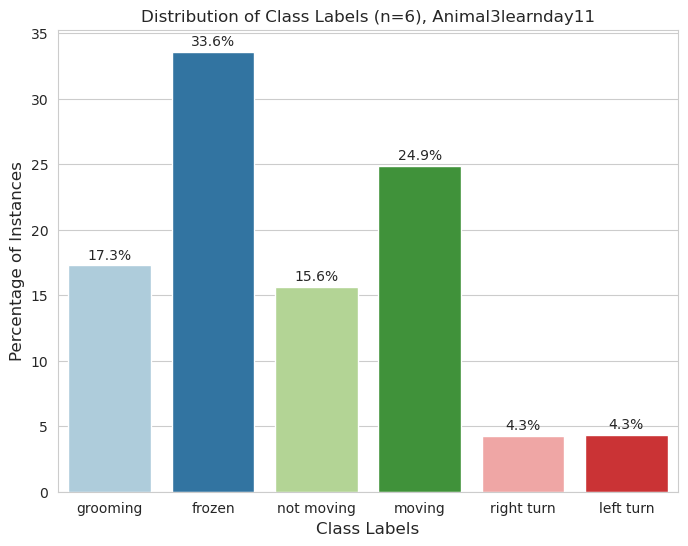

In [30]:
if labels_type == 'old':
    class_counts, total_counts = check_class_imbalance_old(df_new_annotations, experiment_ID, save_dir)
else:
    class_counts, total_counts = check_class_imbalance_new(df_new_annotations, experiment_ID, save_dir, df_new_annotations_unique, df_new_annotations_check, no_of_labels, data_file, label_names)

In [31]:
labels = df_new_annotations.values

In [32]:
labels

array([0, 0, 0, ..., 3, 3, 3], dtype=object)

In [33]:
labels.shape

(24589,)

In [34]:
type(labels)

numpy.ndarray

In [35]:
# data verification
# plt.plot(traces[50])

In [36]:
type(traces[50])

numpy.ndarray

In [37]:
traces.shape

(110, 24589)

In [38]:
num_classes = len(df_new_annotations_unique)

In [39]:
num_classes

6

In [40]:
# traces, labels, num_classes = model_preprocessing(traces, labels, df_new_annotations_unique)

In [41]:
# labels

In [42]:
labels = labels.astype(np.int32)

## Perform k-fold cross validation for the SVM

In [43]:
mySVC = sklearn.svm.LinearSVC()

### Run the SVM for the regular and shuffled labels with K-Fold CV

In [44]:
def add_time_to_model(train_data, n_steps):
    
    new_train_data = []
    
    for i in range(n_steps):
        new_train_data.append(np.roll(train_data, i - n_steps//2, axis=0))

        
    new_train_data = np.hstack(new_train_data)

    return new_train_data

In [45]:
new_train_data = add_time_to_model(traces.T, n_steps=5)

In [46]:
# Create and fit the classifier
mySVC = LinearSVC()
mySVC.fit(new_train_data, labels)

# Perform cross-validation
n_splits = 5
n_steps = 5
kf = KFold(n_splits=n_splits)
y_pred = cross_val_predict(mySVC, new_train_data, labels, cv=kf)
y_pred_prob = cross_val_predict(mySVC, new_train_data, labels, cv=kf, method='decision_function')

# Shuffle the labels
shuffled_labels = np.roll(labels, 15000, axis=0)

# Calculate accuracy and loss for each fold
accuracies = []
losses = []
cm_avg = []
shuffled_accuracies = []
shuffled_losses = []
shuffled_cm_avg = []
f1_score_val_list = []
f1_score_val_list_shuffle = []

for train_index, test_index in kf.split(new_train_data):
    X_train, X_test = new_train_data[train_index], new_train_data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    shuffled_y_train, shuffled_y_test = shuffled_labels[train_index], shuffled_labels[test_index]
    
    mySVC.fit(X_train, y_train)
    y_pred_fold = mySVC.predict(X_test)
    y_pred_prob_fold = mySVC.decision_function(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred_fold))
    losses.append(log_loss(y_test, y_pred_prob_fold))
    cm = confusion_matrix(y_test, y_pred_fold)
    cm_avg.append(cm)
    
    # Find the f1 score
    f1_score_val = f1_score(y_test, y_pred_fold, average='micro')
    print("F1 score is: {:.3f}".format(f1_score_val))
    f1_score_val_list.append(f1_score_val)
    
    mySVC.fit(X_train, shuffled_y_train)
    shuffled_y_pred_fold = mySVC.predict(X_test)
    shuffled_y_pred_prob_fold = mySVC.decision_function(X_test)
    
    shuffled_accuracies.append(accuracy_score(y_test, shuffled_y_pred_fold))
    shuffled_losses.append(log_loss(y_test, shuffled_y_pred_prob_fold))
    shuffled_cm = confusion_matrix(y_test, shuffled_y_pred_fold)
    shuffled_cm_avg.append(shuffled_cm)
    
    # Find the f1 score for shuffled labels
    f1_score_val_shuffle = f1_score(y_test, shuffled_y_pred_fold, average='micro')
    print("F1 score is: {:.3f}".format(f1_score_val_shuffle))
    f1_score_val_list_shuffle.append(f1_score_val_shuffle)

/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmc/

F1 score is: 0.541


/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


F1 score is: 0.296


/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


F1 score is: 0.454


/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


F1 score is: 0.264


/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


F1 score is: 0.366


/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


F1 score is: 0.215


/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


F1 score is: 0.412


/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


F1 score is: 0.245


/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


F1 score is: 0.374
F1 score is: 0.239


/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [47]:
mean_f1 = np.mean(f1_score_val_list)
mean_f1_shuffle = np.mean(f1_score_val_list_shuffle)
    
# Print results
print("Normal Accuracy:", accuracies)
print("Shuffled Accuracy:", shuffled_accuracies)
print("Normal Loss:", losses)
print("Shuffled Loss:", shuffled_losses)
print("Normal F1_score", mean_f1)
print("Shuffle F1_score", mean_f1_shuffle)

Normal Accuracy: [0.541276941846279, 0.4544530296868646, 0.36559577063847093, 0.412159414396096, 0.3740085417937767]
Shuffled Accuracy: [0.29564863765758437, 0.26372509150061, 0.2145180967873119, 0.24461163074420497, 0.2387634736628025]
Normal Loss: [8.411097405177129, 11.751622814849688, 13.920237268092354, 13.00270999832148, 13.086513514001613]
Shuffled Loss: [15.663091863295149, 15.667469413666451, 17.154492769076043, 14.834205258223319, 14.307930204405082]
Normal F1_score 0.42949873967229746
Shuffle F1_score 0.25145338607050277


### Plot Everything

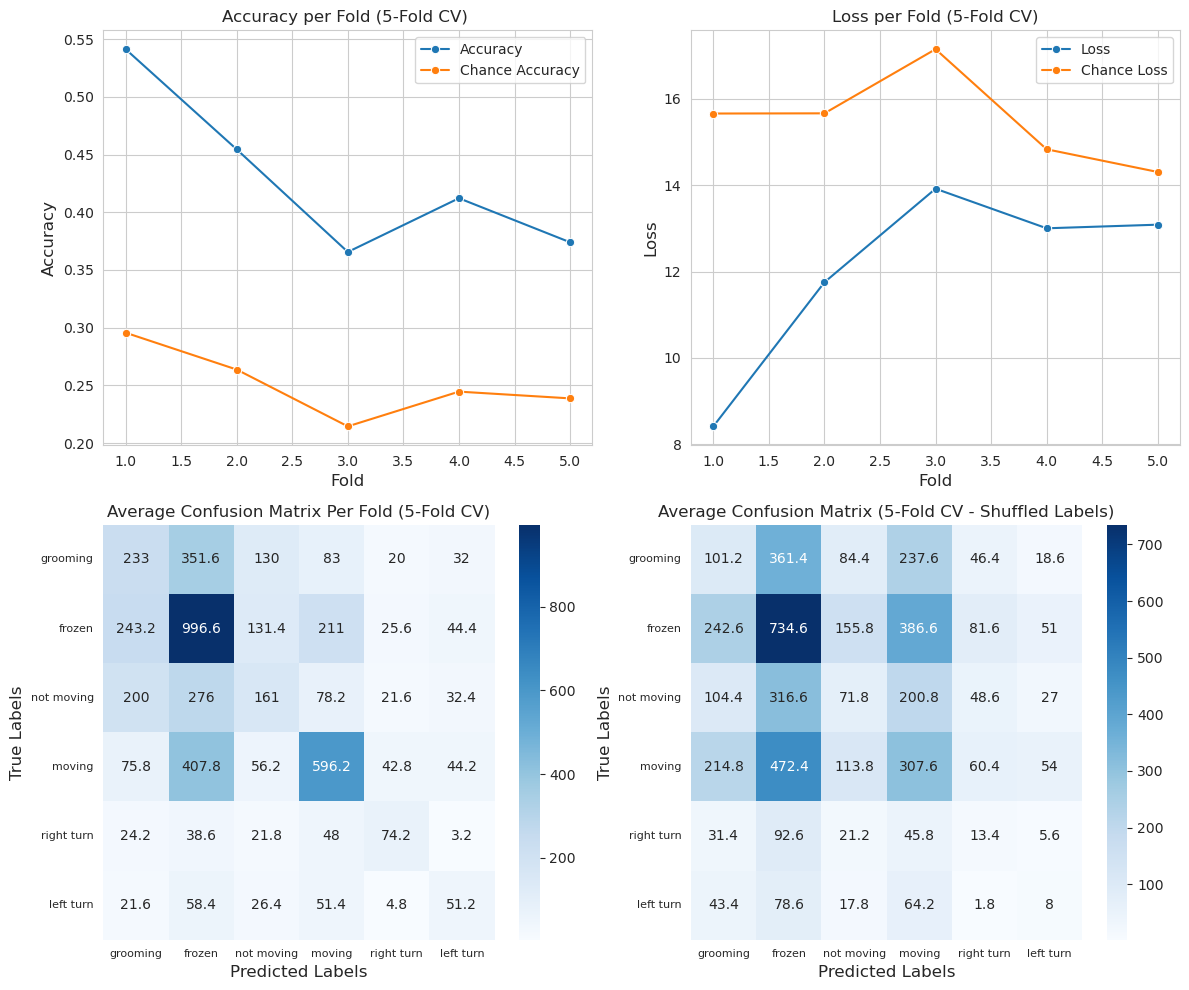

In [49]:
# Plotting
n_splits = 5

plt.figure(figsize=(12, 10))

# Accuracy and Shuffled Accuracy
plt.subplot(2, 2, 1)
sns.lineplot(x=np.arange(1, n_splits+1), y=accuracies, marker='o', label='Accuracy')
sns.lineplot(x=np.arange(1, n_splits+1), y=shuffled_accuracies, marker='o', label='Chance Accuracy')
plt.xlabel("Fold", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy per Fold (5-Fold CV) ")
plt.legend()

# Loss and Shuffled Loss
plt.subplot(2, 2, 2)
sns.lineplot(x=np.arange(1, n_splits+1), y=losses, marker='o', label='Loss')
sns.lineplot(x=np.arange(1, n_splits+1), y=shuffled_losses, marker='o', label='Chance Loss')
plt.xlabel("Fold", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss per Fold (5-Fold CV)")
plt.legend()

# Average Confusion Matrix for Regular Labels
plt.subplot(2, 2, 3)
train_labels_names = ['moving', 'rightTurn', 'immobile', 'grooming', 'still', 'leftTurn']
sns.heatmap(np.mean(cm_avg, axis=0), annot=True, cmap='Blues', fmt='g')
plt.title('Average Confusion Matrix Per Fold (5-Fold CV)')
plt.xlabel('Predicted Labels', fontsize=12)
plt.xticks(np.arange(len(label_names)) + 0.5, label_names, ha='center', fontsize=8)
plt.ylabel('True Labels', fontsize=12)
plt.yticks(np.arange(len(label_names)) + 0.5, label_names, rotation=0, fontsize=8)

# Average Confusion Matrix for Shuffled Labels
plt.subplot(2, 2, 4)
sns.heatmap(np.mean(shuffled_cm_avg, axis=0), annot=True, cmap='Blues', fmt='g')
plt.title('Average Confusion Matrix (5-Fold CV - Shuffled Labels)')
plt.xlabel('Predicted Labels', fontsize=12)
plt.xticks(np.arange(len(label_names)) + 0.5, label_names, ha='center', fontsize=8)
plt.ylabel('True Labels', fontsize=12)
plt.yticks(np.arange(len(label_names)) + 0.5, label_names, rotation=0, fontsize=8)


save_SVM_plots = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/4-BPSVM_output/"
plt.savefig(save_SVM_plots+"/accuracy_loss_cm_regular_shuffled_labels.svg", dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [56]:
accuracies

[0.541276941846279,
 0.4544530296868646,
 0.36559577063847093,
 0.412159414396096,
 0.3740085417937767]

In [57]:
shuffled_accuracies

[0.29564863765758437,
 0.26372509150061,
 0.2145180967873119,
 0.24461163074420497,
 0.2387634736628025]

### Save results in the folder to reproduce later if needed

In [50]:
# create pickles directory
dir_name_pickles = os.path.join(output_dir, 'results')
if not os.path.exists(dir_name_pickles):
    os.mkdir(dir_name_pickles)

# save pickle files
with open(os.path.join(dir_name_pickles, 'shuffled_accuracies.pkl'), 'wb') as f:
    pickle.dump(shuffled_accuracies, f)
    
# save pickle files
with open(os.path.join(dir_name_pickles, 'accuracies.pkl'), 'wb') as f:
    pickle.dump(accuracies, f)

with open(os.path.join(dir_name_pickles, 'losses.pkl'), 'wb') as f:
    pickle.dump(losses, f)

with open(os.path.join(dir_name_pickles, 'shuffled_losses.pkl'), 'wb') as f:
    pickle.dump(shuffled_losses, f)

with open(os.path.join(dir_name_pickles, 'train_labels_names.pkl'), 'wb') as f:
    pickle.dump(train_labels_names, f)
    
with open(os.path.join(dir_name_pickles, 'cm_avg.pkl'), 'wb') as f:
    pickle.dump(cm_avg, f)

with open(os.path.join(dir_name_pickles, 'shuffled_cm_avg.pkl'), 'wb') as f:
    pickle.dump(shuffled_cm_avg, f)

In [51]:
mean_accuracies = np.mean(accuracies)

In [52]:
mean_accuracies

0.42949873967229746

In [54]:
mean_shuffled_accuracies = np.mean(shuffled_accuracies)

In [55]:
mean_shuffled_accuracies

0.25145338607050277

In [ ]:
experiment_ID

In [ ]:
data_file

In [ ]:
no_of_labels

In [ ]:
output_dir

In [ ]:
# f1_score_mean = np.mean(f1_score_val_list)
# f1_score_mean_shuffle = np.mean(f1_score_val_list_shuffle)

In [ ]:
save_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/"+str(output_dir)

In [ ]:

# import os
# import pickle

# # Load files:
# load_existing_data = True

# if load_existing_data == True:
    
#     directory = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/4-BPSVM_output/results"
    
#     with open(os.path.join(directory,'cm_avg.pkl'), 'rb') as f:
#         cm_avg = pickle.load(f)

#     with open(os.path.join(directory,'losses.pkl'), 'rb') as f:
#         losses = pickle.load(f)

#     with open(os.path.join(directory,'shuffled_accuracies.pkl'), 'rb') as f:
#         shuffled_accuracies = pickle.load(f)

#     with open(os.path.join(directory,'shuffled_cm_avg.pkl'), 'rb') as f:
#         shuffled_cm_avg = pickle.load(f)
        
#     with open(os.path.join(directory,'shuffled_losses.pkl'), 'rb') as f:
#         shuffled_losses = pickle.load(f)

#     with open(os.path.join(directory,'train_labels_names.pkl'), 'rb') as f:
#         train_labels_names = pickle.load(f)

        
# n_splits = 5
# plt.figure(figsize=(12, 10))
# # Accuracy and Shuffled Accuracy
# plt.subplot(2, 2, 1)
# # sns.lineplot(x=np.arange(1, n_splits+1), y=shuffled_accuracies, marker='o', label='Accuracy')
# sns.lineplot(x=np.arange(1, n_splits+1), y=shuffled_accuracies, marker='o', label='Shuffled Accuracy')
# plt.xlabel("Fold")
# plt.ylabel("Chance Accuracy")
# plt.title("Chance Accuracy per Fold (10-Fold CV)")
# plt.legend()






In [ ]:
save_training_info(experiment_ID=experiment_ID,
                   data_file = data_file,
                   no_of_labels = no_of_labels,
                   comment=comment,
                   save_dir=save_dir,
                   f1_score_mean = mean_f1
                  )

In [ ]:
save_training_info(experiment_ID=experiment_ID+str("-shuffled"),
                   data_file = data_file,
                   no_of_labels = no_of_labels,
                   comment=comment,
                   save_dir=save_dir,
                   f1_score_mean = mean_f1_shuffle
                  )

### Shuffle Labels Randomly

In [ ]:
# Shuffle the labels
# shuffled_labels = np.random.permutation(labels)

shuffled_labels = np.roll(labels, 15000, axis=0)


# Use the shuffled labels for cross-validation
y_pred = cross_val_predict(mySVC, traces.T, shuffled_labels, cv=kf)

# Calculate accuracy using shuffled labels
accuracy = accuracy_score(shuffled_labels, y_pred)
print("Shuffled accuracy:", accuracy)